Here we analyze the price data of FFR and FCR from the sheets

In [2]:
import pandas as pd
import numpy as np

C:\Users\carlv\AppData\Local\Temp\ipykernel_29132\2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df_fcr = pd.read_csv("data/FCR_2024.csv", on_bad_lines='skip', sep=';')

In [4]:
# modifications for nicer readibility
df_fcr.iloc[:, 1] = df_fcr.iloc[:, 1].replace(',', '.', regex=True).astype(float).round(2)
df_fcr = df_fcr.iloc[:-1 , :]
df_fcr["Datum"] = pd.to_datetime(df_fcr["Datum"], format='mixed')   #"%Y-%M-%D %H:%M:%S")  # 2025-02-01 22:00:00

In [5]:
df_ffr_2024 = pd.read_excel('data/FFR_2024.xlsx')
df_ffr_2023 = pd.read_excel('data/FFR_2023.xlsx')
df_ffr_2022 = pd.read_excel('data/FFR_2022.xlsx')
SEK_TO_EURO = 0.09

In [6]:
df_ffr_fingrid = pd.read_csv("data/FFR_Fingrid.csv", on_bad_lines='skip', sep=';')

In [7]:
def format_ffr(df, year_offset, name) -> pd.DataFrame:
    df.columns = df.iloc[1, :]
    df = df.iloc[2:, 0:2]
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(float) * SEK_TO_EURO
    df.rename(columns={'Timme': 'Datum', 'Marginalpris (SEK/MW)': f'FFR (EUR/MW) {name}'}, inplace=True)
    df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
    # add one year because of year mismatch
    if year_offset:  df["Datum"] = df["Datum"] + pd.DateOffset(years=year_offset)
    return df

In [8]:
df_ffr_fingrid.drop('endTime', inplace=True, axis=1)
df_ffr_fingrid.rename(columns={'startTime': 'Datum', 'Fast Frequency Reserve FFR, price': 'FFR (EUR/MW) Fingrid'}, inplace=True)
df_ffr_fingrid["Datum"] = pd.to_datetime(df_ffr_fingrid["Datum"], format='mixed')

In [9]:
df_ffr_2024 = format_ffr(df_ffr_2024, year_offset=0, name='2024')
df_ffr_2023 = format_ffr(df_ffr_2023, year_offset=1, name='2023')
df_ffr_2022 = format_ffr(df_ffr_2022, year_offset=2, name='2022')
df_ffrs = [df_ffr_2024, df_ffr_2023, df_ffr_2022]

In [10]:
# merge
df_merged = df_fcr[['Datum', 'FCR-N Pris (EUR/MW)']]
for df in df_ffrs:
    df_merged = pd.merge(df_merged, df, on='Datum', how='left')

## FFR and FCR-N

<Axes: xlabel='Datum'>

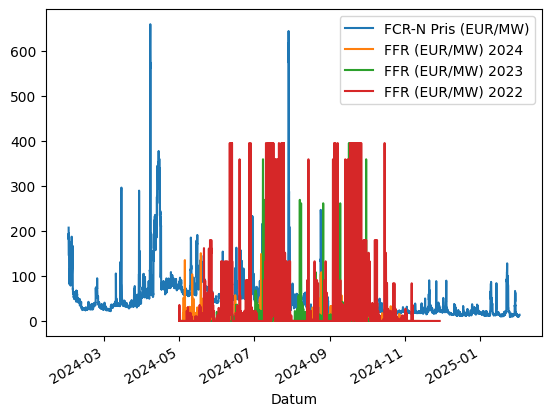

In [11]:
df_merged.plot(x='Datum')

C:\Users\carlv\AppData\Local\Temp\ipykernel_29132\751878038.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_notna.fillna(0).plot(kind='hist', alpha=0.5, bins=30)


<Axes: ylabel='Frequency'>

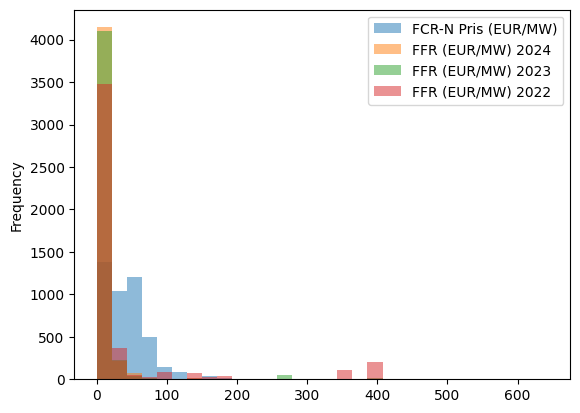

In [12]:
# make historgram with FFR prices
df_merged_notna = df_merged.dropna(subset=['FFR (EUR/MW) 2024', 'FFR (EUR/MW) 2023', 'FFR (EUR/MW) 2022'])
df_merged_notna.fillna(0).plot(kind='hist', alpha=0.5, bins=30)

C:\Users\carlv\AppData\Local\Temp\ipykernel_29132\3983047806.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_notna['FCR-N Pris (EUR/MW)'].fillna(0).plot(kind='hist', alpha=0.5, bins=30)


<Axes: ylabel='Frequency'>

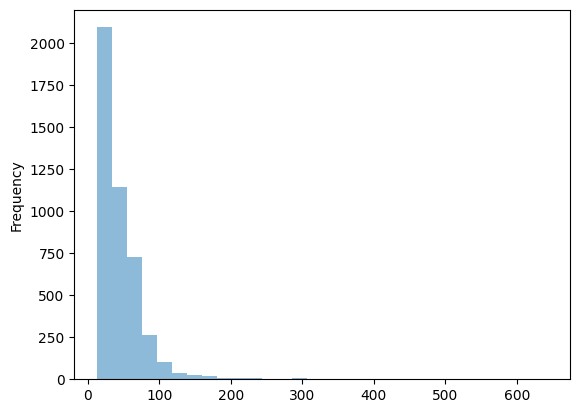

In [13]:
df_merged_notna['FCR-N Pris (EUR/MW)'].fillna(0).plot(kind='hist', alpha=0.5, bins=30)

<Axes: xlabel='Datum'>

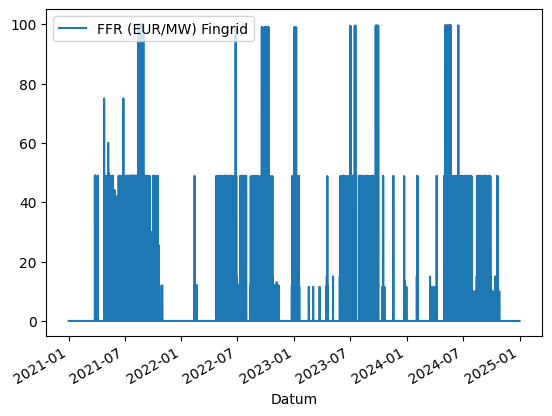

In [14]:
df_ffr_fingrid.plot(x='Datum', y='FFR (EUR/MW) Fingrid')

## mean values comparison

In [15]:
pd.options.display.float_format = '{:,.3f}'.format
print("Mean of Fingrid price EUR/MW:", df_ffr_fingrid['FFR (EUR/MW) Fingrid'].mean())
print("Mean of p>0 Fingrid price EUR/MW:", df_ffr_fingrid[df_ffr_fingrid['FFR (EUR/MW) Fingrid'] > 0]['FFR (EUR/MW) Fingrid'].mean())

Mean of Fingrid price EUR/MW: 5.187817228595891
Mean of p>0 Fingrid price EUR/MW: 33.2566988090011


In [16]:
df_merged.describe()

,Datum
count,8810
mean,2024-08-02 12:32:47.952326912
min,2024-02-01 00:00:00
25%,2024-05-02 19:15:00
50%,2024-08-02 13:30:00
75%,2024-11-02 04:45:00
max,2025-02-01 23:00:00


In [17]:
df_merged.fillna(0).describe()

C:\Users\carlv\AppData\Local\Temp\ipykernel_29132\858709426.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged.fillna(0).describe()


,Datum,FCR-N Pris (EUR/MW),FFR (EUR/MW) 2024,FFR (EUR/MW) 2023,FFR (EUR/MW) 2022
count,8810,"8,810.000","8,810.000","8,810.000","8,810.000"
mean,2024-08-02 12:32:47.952326912,45.437,3.247,4.407,19.144
min,2024-02-01 00:00:00,8.640,0.000,0.000,0.000
25%,2024-05-02 19:15:00,19.660,0.000,0.000,0.000
50%,2024-08-02 13:30:00,30.880,0.000,0.000,0.000
75%,2024-11-02 04:45:00,54.932,0.000,0.000,0.000
max,2025-02-01 23:00:00,658.380,150.300,394.650,394.650
std,NaN,48.684,11.137,28.766,72.646


# FCR-D Upwards market analysis

In [18]:
df_fcrd = pd.read_csv("data/FCR-D_UP.csv", on_bad_lines='skip', sep=';')
df_fcrd.drop('endTime', inplace=True, axis=1)
df_fcrd.rename(columns={'startTime': 'Datum'}, inplace=True)
df_fcrd["Datum"] = pd.to_datetime(df_fcrd["Datum"], format='mixed')
df_fcrd.set_index('Datum', inplace=True)
cols = df_fcrd.columns.tolist()
cols = [c[len("Frequency Containment Reserve for Disturbances upwards regulation, "):] for c in cols]
df_fcrd.columns = cols
df_fcrd.head()

,received bids in the hourly market,nordic trade,reserve plans in the yearly market,procured volumes in the hourly market,hourly market prices
Datum,,,,,
2020-12-31 23:00:00+00:00,283.500,-163.300,365.700,94.900,3.000
2021-01-01 00:00:00+00:00,284.000,-164.800,366.700,95.400,3.000
2021-01-01 01:00:00+00:00,289.000,-164.700,366.600,95.400,3.000
2021-01-01 02:00:00+00:00,289.000,-165.600,367.500,95.400,3.000
2021-01-01 03:00:00+00:00,294.500,-172.600,369.000,100.900,3.000


array([[<Axes: xlabel='Datum'>, <Axes: xlabel='Datum'>,
        <Axes: xlabel='Datum'>],
       [<Axes: xlabel='Datum'>, <Axes: xlabel='Datum'>,
        <Axes: xlabel='Datum'>],
       [<Axes: xlabel='Datum'>, <Axes: xlabel='Datum'>,
        <Axes: xlabel='Datum'>]], dtype=object)

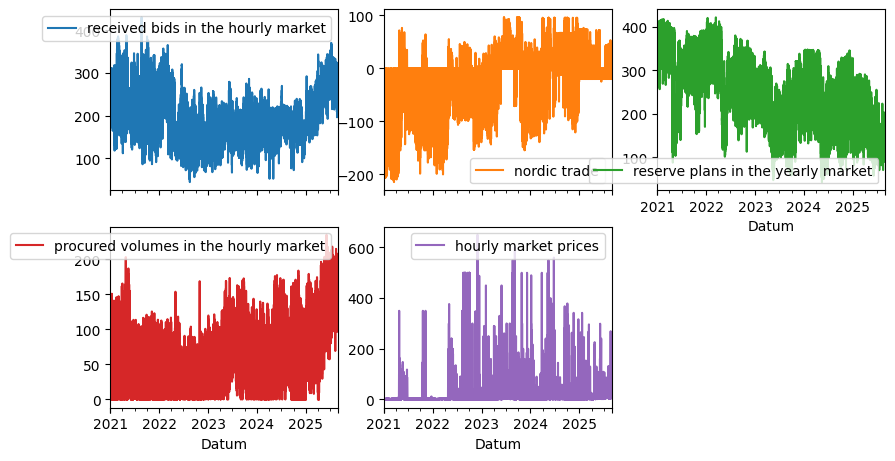

In [19]:
# plot
df_fcrd.plot(subplots=True, layout=(3,3), figsize=(10,8))

In [20]:
df_fcrd.describe()

,received bids in the hourly market,nordic trade,reserve plans in the yearly market,procured volumes in the hourly market,hourly market prices
count,"40,847.000","40,847.000","40,847.000","40,847.000","40,847.000"
mean,199.543,-29.372,250.291,64.345,15.798
std,56.538,56.664,77.798,41.789,43.321
min,43.900,-214.700,43.500,0.000,0.000
25%,158.000,-72.350,191.300,34.100,1.800
50%,191.200,0.000,255.500,60.300,2.840
75%,240.200,0.000,306.600,87.600,8.000
max,430.400,96.400,422.100,234.900,650.000


# Renewable Production in Fingrid

In [65]:
df = pd.read_csv('data/data_wind_solar_2024_25.csv', sep=';')
df.drop('endTime', inplace=True, axis=1)
df.rename(columns={'startTime': 'Datum'}, inplace=True)
df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
df.set_index('Datum', inplace=True)
df.columns = [col1, 'Solar']
df.head()

,"Fast Frequency Reserve FFR, procured volume",Solar
Datum,,
2024-07-31 22:00:00+00:00,970.819,0.000
2024-07-31 22:15:00+00:00,968.006,0.000
2024-07-31 22:30:00+00:00,959.571,0.000
2024-07-31 22:45:00+00:00,902.011,0.000
2024-07-31 23:00:00+00:00,867.776,0.000


array([[<Axes: xlabel='Datum'>],
       [<Axes: xlabel='Datum'>]], dtype=object)

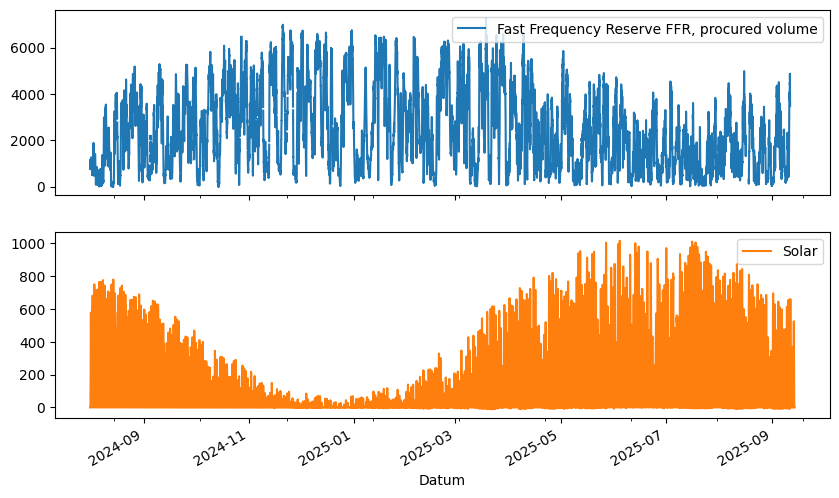

In [66]:
# plot
df.plot(subplots=True, layout=(2,1), figsize=(10,6))

In [67]:
import matplotlib.pyplot as plt

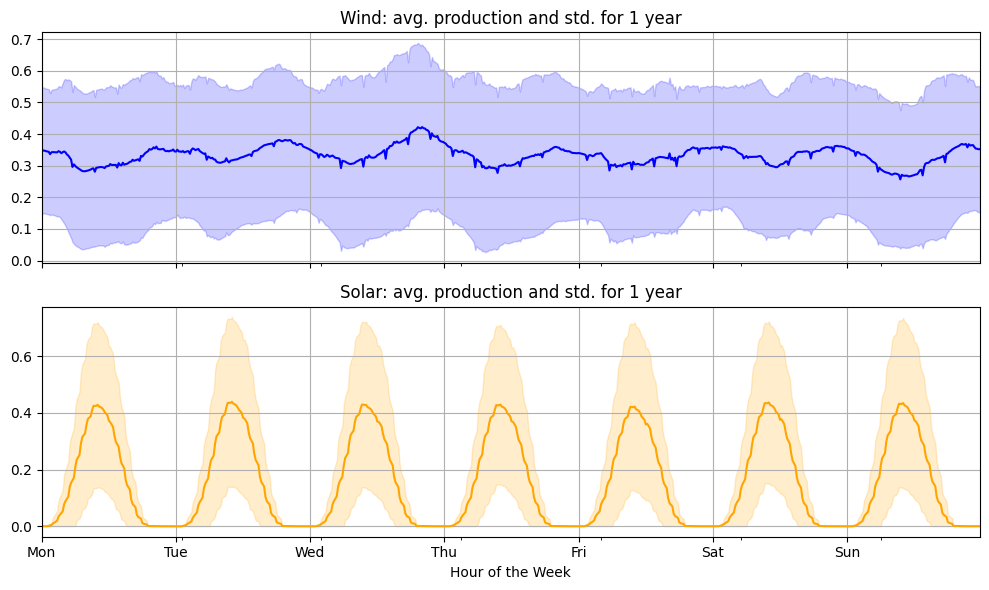

In [ ]:
# create weekly profile by averaging for every time of the week and creating std
idxes = 24 * 7 * 4  # 15 min intervals
df_mean = df.groupby([df.index.dayofweek, df.index.hour, df.index.minute]).mean()
df_std = df.groupby([df.index.dayofweek, df.index.hour, df.index.minute]).std()
df_mean.index = pd.MultiIndex.from_tuples(df_mean.index, names=['Wochentag', 'Stunde', 'Minute'])
df_std.index = pd.MultiIndex.from_tuples(df_std.index, names=['Wochentag', 'Stunde', 'Minute'])

# normalize to max 1
max_vals = df.max()
df_mean = df_mean / max_vals
df_std = df_std / max_vals

col1, col2 = df.columns

# plot mean with std as shaded area
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
df_mean[col1].plot(ax=ax[0], title='Wind: avg. production and std. for 1 year', color='b')
df_mean[col2].plot(ax=ax[1], title='Solar: avg. production and std. for 1 year', color='orange')
# add std as shaded area
ax[0].fill_between(np.arange(0, idxes), 
                   (df_mean[col1] - df_std[col1]).values.flatten(), 
                   (df_mean[col1] + df_std[col1]).values.flatten(), 
                   color='b', alpha=0.2)

lower = df_mean[col2] - df_std[col2]
lower[lower < 0] = 0
ax[1].fill_between(np.arange(0, idxes), 
                   lower.values.flatten(), 
                   (df_mean[col2] + df_std[col2]).values.flatten(), 
                   color='orange', alpha=0.2)

plt.xlabel('Hour of the Week')
# xticks: day + hour
plt.xticks(ticks=np.arange(0, idxes, idxes/7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlim(0, idxes-1)
plt.tight_layout()
ax[0].grid()
ax[1].grid()
plt.show()

In [70]:
# do same for procurement
df = pd.read_csv('data/data_ffr_fcr_procurement_2024_25.csv', sep=';')
df.drop('endTime', inplace=True, axis=1)
df.rename(columns={'startTime': 'Datum'}, inplace=True)
df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
df.set_index('Datum', inplace=True)
# df.columns = ['FFR ', 'Solar']
df.head()

,"Fast Frequency Reserve FFR, procured volume","Frequency Containment Reserve for Disturbances upwards regulation, procured volumes in the hourly market"
Datum,,
2024-07-31 22:00:00+00:00,0.000,100.700
2024-07-31 23:00:00+00:00,0.000,86.000
2024-08-01 00:00:00+00:00,0.000,66.400
2024-08-01 01:00:00+00:00,0.000,36.700
2024-08-01 02:00:00+00:00,0.000,39.500


array([[<Axes: xlabel='Datum'>],
       [<Axes: xlabel='Datum'>]], dtype=object)

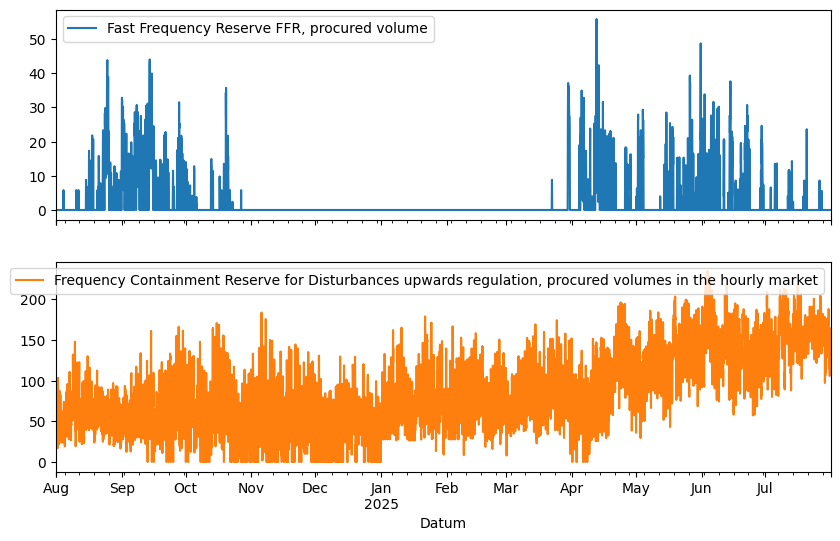

In [71]:
# plot
df.plot(subplots=True, layout=(2,1), figsize=(10,6))

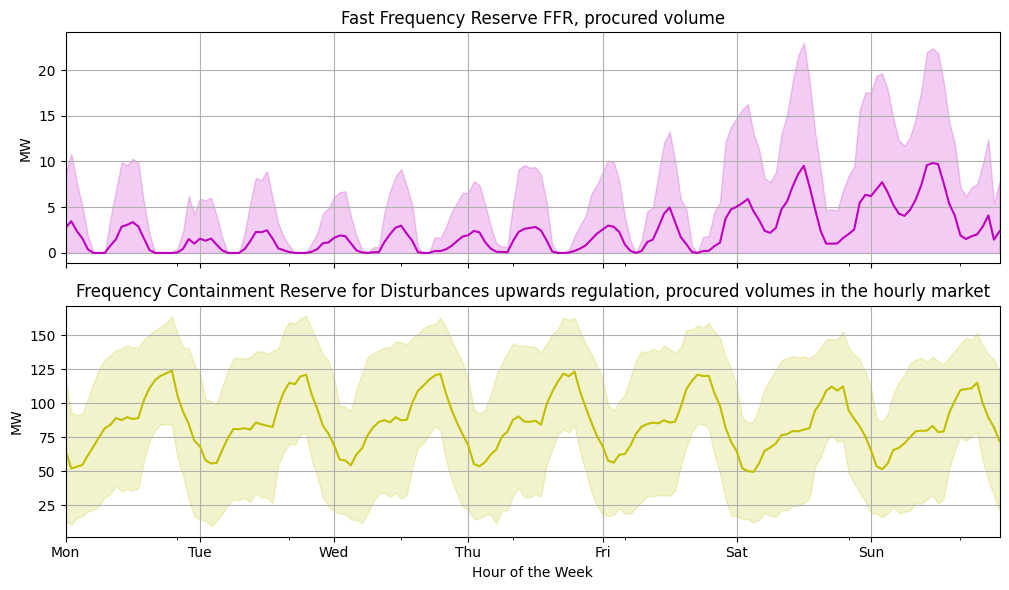

In [76]:
# create weekly profile by averaging for every time of the week and creating std
idxes = 24 * 7  # 15 min intervals
df_mean = df.groupby([df.index.dayofweek, df.index.hour, df.index.minute]).mean()
df_std = df.groupby([df.index.dayofweek, df.index.hour, df.index.minute]).std()
df_mean.index = pd.MultiIndex.from_tuples(df_mean.index, names=['Wochentag', 'Stunde', 'Minute'])
df_std.index = pd.MultiIndex.from_tuples(df_std.index, names=['Wochentag', 'Stunde', 'Minute'])

# # normalize to max 1
# max_vals = df.max()
# df_mean = df_mean / max_vals
# df_std = df_std / max_vals

col1, col2 = df.columns

# plot mean with std as shaded area
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
df_mean[col1].plot(ax=ax[0], title=col1, color='m')
df_mean[col2].plot(ax=ax[1], title=col2, color='y')
# add std as shaded area
lower = df_mean[col1] - df_std[col1]
lower[lower < 0] = 0
ax[0].fill_between(np.arange(0, idxes), 
                   lower.values.flatten(), 
                   (df_mean[col1] + df_std[col1]).values.flatten(), 
                   color='m', alpha=0.2)

lower = df_mean[col2] - df_std[col2]
lower[lower < 0] = 0
ax[1].fill_between(np.arange(0, idxes), 
                   lower.values.flatten(), 
                   (df_mean[col2] + df_std[col2]).values.flatten(), 
                   color='y', alpha=0.2)

plt.xlabel('Hour of the Week')
# xticks: day + hour
plt.xticks(ticks=np.arange(0, idxes, idxes/7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlim(0, idxes-1)
plt.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].set_ylabel('MW')
ax[1].set_ylabel('MW')
plt.show()

In [86]:
# construct probability distribution by weighting probability compared to other hours
# basically nor
df_prob = df_mean / df_mean.sum()
# next, split up every row into 4 values for 15 min intervals
df_prob_15min = pd.DataFrame(np.repeat(df_prob.values, 4, axis=0), columns=df_prob.columns)
df_prob_15min.index = pd.RangeIndex(start=0, stop=len(df_prob_15min), step=1)
df_prob_15min = df_prob_15min / df_prob_15min.sum()

In [88]:
# save to df
df_prob_15min.to_csv('data/procurement_probability_distribution_15min.csv', sep=';')

In [93]:
df_prob_15min

,"Fast Frequency Reserve FFR, procured volume","Frequency Containment Reserve for Disturbances upwards regulation, procured volumes in the hourly market"
0,0.002,0.001
1,0.002,0.001
2,0.002,0.001
3,0.002,0.001
4,0.002,0.001
...,...,...
667,0.001,0.001
668,0.002,0.001
669,0.002,0.001
670,0.002,0.001


In [92]:
df_prob_15min.iloc[:, 0]

0     0.002
1     0.002
2     0.002
3     0.002
4     0.002
       ... 
667   0.001
668   0.002
669   0.002
670   0.002
671   0.002
Name: Fast Frequency Reserve FFR, procured volume, Length: 672, dtype: float64